# Custom Dataset


Custom dataset is a collection of data relating to a specific problem you're working on


## Import


In [ ]:
import torch
import torchvision
import torchmetrics
import requests
import matplotlib.pyplot as plt
import numpy
import zipfile


from pathlib import Path
from torch import nn


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## Get our dataset


In [ ]:
def download_and_extract_zip(
    url: str, download_dir: Path, zip_filename: str, extract_to: str
):
    """
    Downloads a ZIP file from the given URL and extracts it.

    Args:
        url (str): URL to the ZIP file.
        download_dir (Path): Path object where ZIP file will be saved and data extracted.
        zip_filename (str): Name of the ZIP file to save.
        extract_to (str): Name of the directory to extract contents into (relative to download_dir).
    """
    download_dir.mkdir(parents=True, exist_ok=True)

    zip_path = download_dir / zip_filename
    extract_path = download_dir / extract_to

    print(f"Downloading ZIP file from {url}...")
    response = requests.get(url)
    zip_path.write_bytes(response.content)

    print(f"Extracting to {extract_path}...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(path=extract_path)

    try:
        zip_path.unlink()
        print("ZIP file deleted.")
    except Exception as e:
        print(f"Failed to delete ZIP file: {e}")

    print("Download and extraction complete.")


In [ ]:
URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip"
PATH = Path("../Data")
ZIP = "custom_data.zip"
IMAGE = "piza_sushi"

download_and_extract_zip(URL, PATH, ZIP, IMAGE)


Extracting to ../Data/piza_sushi...
ZIP file deleted.
Download and extraction complete.


## Preparing the dataset


In [5]:
!nvidia-smi


Fri May 30 21:31:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Our dataset is a subset of [food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) this dataset  
has 101 different classes and there are 750 images per class

We will be using a subset of this dataset with 3 class with 10% of the data


## Becoming one with the data


In [ ]:
import os


def walk_dir(dir_path: Path):
    """Give a info about the dir"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'"
        )


In [ ]:
dir_path = Path("../Data/piza_sushi")
walk_dir(dir_path)


There are 2 directories and 0 images in '../Data/piza_sushi'
There are 3 directories and 0 images in '../Data/piza_sushi/test'
There are 0 directories and 46 images in '../Data/piza_sushi/test/sushi'
There are 0 directories and 58 images in '../Data/piza_sushi/test/steak'
There are 0 directories and 46 images in '../Data/piza_sushi/test/pizza'
There are 3 directories and 0 images in '../Data/piza_sushi/train'
There are 0 directories and 150 images in '../Data/piza_sushi/train/sushi'
There are 0 directories and 146 images in '../Data/piza_sushi/train/steak'
There are 0 directories and 154 images in '../Data/piza_sushi/train/pizza'


Image path: ../Data/piza_sushi/train/pizza/3196721.jpg
Image class: pizza
Image width: 512
Image height: 384


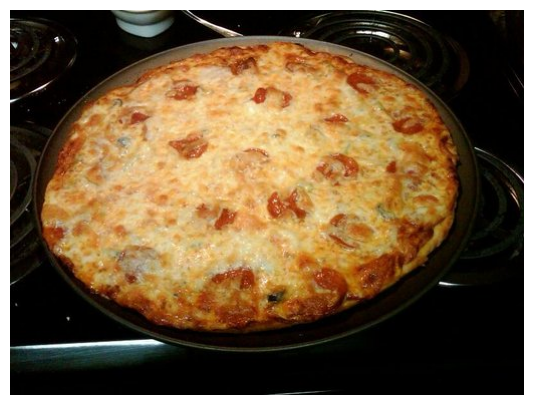

In [ ]:
# visualizing image

# get all of the image path
# get a random path of the image using random.choice
# get the image class name using pathlib.path.parent.stem
# Open the image using PIL - python.pillow
# show the image and print some metadata

import random
from PIL import Image

# random.seed(42)

image_path = Path("../Data/piza_sushi")

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)


image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image width: {img.width}")
print(f"Image height: {img.height}")

plt.figure(figsize=(10, 5))
plt.axis(False)
plt.imshow(img)


## Transforming Data


In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [ ]:
data_transform = transforms.Compose(
    [
        # resize the all the image into same height and width
        transforms.Resize((64, 64)),
        # flip some of the images
        transforms.RandomHorizontalFlip(p=0.5),
        # Turn the image into a tensor
        transforms.ToTensor(),
    ]
)


In [ ]:
test_transformed_image = data_transform(img)
test_transformed_image.shape


torch.Size([3, 64, 64])

In [ ]:
# A function to show transformed image alongside original image


def plot_transformed_images(
    image_path: Path, transforms: torchvision.transforms, n=3, seed=42
):
    random.seed(seed)
    random_image_paths = random.sample(image_path, k=3)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transforms(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


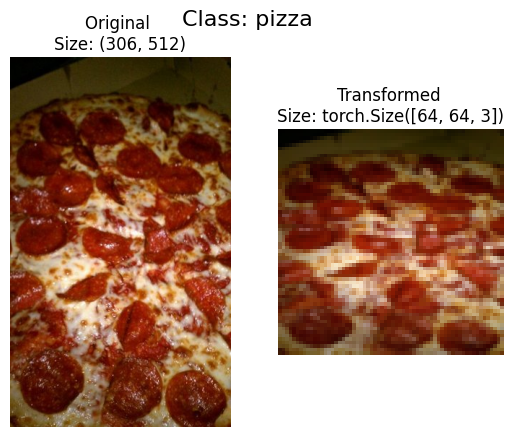

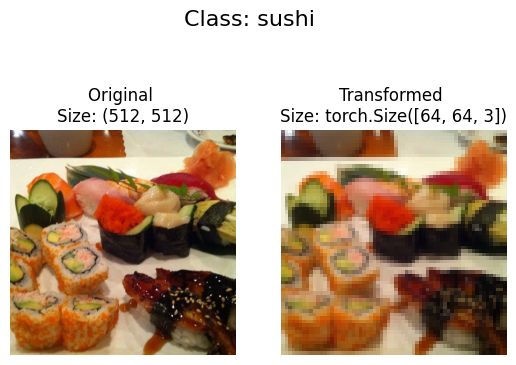

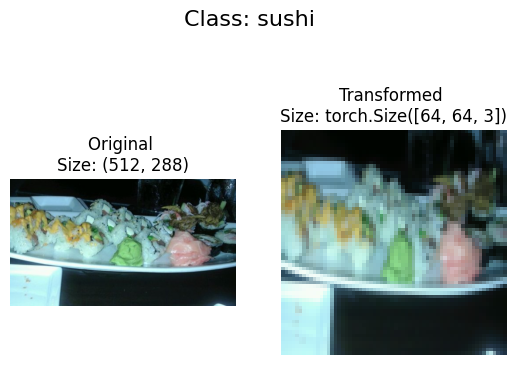

In [ ]:
plot_transformed_images(image_path_list, data_transform)


## Loading Image Data using ImageFolder


In [ ]:
# since our data is in standard image classification format, we ca use the class torchvision.datasets.ImageFolder

train_dir = Path("../Data/piza_sushi/train")
test_dir = Path("../Data/piza_sushi/test")

train_data = datasets.ImageFolder(
    root=train_dir, transform=data_transform, target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir, transform=data_transform, target_transform=None
)

print(f"Train directory : {train_dir}")
print(f"Train data: {train_data}")
print(f"Test dir: {test_dir}")
print(f"Test data : {test_data}")


Train directory : ../Data/piza_sushi/train
Train data: Dataset ImageFolder
    Number of datapoints: 450
    Root location: ../Data/piza_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test dir: ../Data/piza_sushi/test
Test data : Dataset ImageFolder
    Number of datapoints: 150
    Root location: ../Data/piza_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
# we have registered our dataset using pytorch

class_names = train_data.classes
class_to_idx = train_data.class_to_idx

print(f"Classes: {class_names}, Classes with idx: {class_to_idx}")
print(f"{len(train_data), len(test_data)}")


Classes: ['pizza', 'steak', 'sushi'], Classes with idx: {'pizza': 0, 'steak': 1, 'sushi': 2}
(450, 150)


In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")


Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Text(0.5, 1.0, 'pizza')

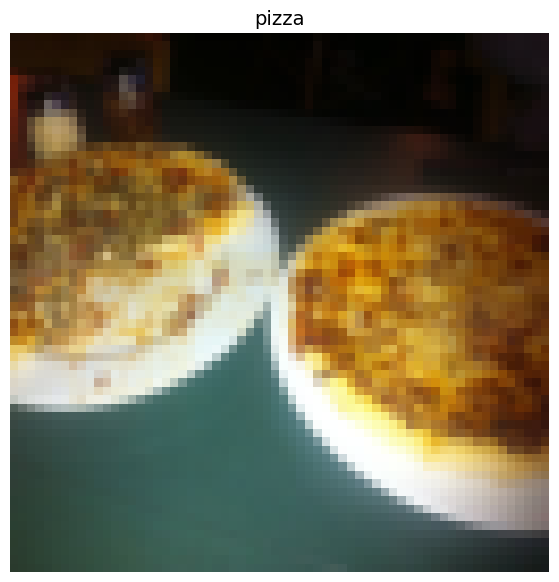

In [ ]:
img_premute = img.permute(1, 2, 0)

plt.figure(figsize=(10, 7))
plt.imshow(img_premute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)


We can see a the image is now more pixelated (less quality) - this is due to it being resized from `512X512` to `64X64`


In [ ]:
import os

os.cpu_count()


8

num_workers in DataLoader - it defines how many subprocesses will be created to load your data.


In [ ]:
# Turing the loaded dataset to dataloader

BATCH_SIZE = 1
NUM_WORKER = 8

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    drop_last=True,
)


test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    drop_last=True,
)


train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7fb27b1c7310>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb27b1c7490>)

In [ ]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")


Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


## Loading Image Data with a custom dataset


Building our own dataset class using `torchvision.datasets.ImageFolder()`

Pros and cons of creating our own custom way to load Dataset's

We will be using:

- Python's `os` for dealing with directories (our data is stored in directories).
- Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).
- `torch` for all things PyTorch.
- PIL's `Image` class for loading images.
- `torch.utils.data.Dataset` to subclass and create our own custom Dataset.
- `torchvision.transforms` to turn our images into tensors.
- Various types from Python's `typing` module to add type hints to our code.


In [ ]:
import os
import torch
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


### Creating a helper function to get class names


In [ ]:
train_data.classes, train_data.class_to_idx

# we will create a helper function to get similar result for our custom_dataset class


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
# get the class name to traverse a target directory
# raise an error if the class names aren't found - this means error in the directory structure
# turn the class names into a dictionary of numerical labels for each class

target_dir = train_dir
print(f"Target directory: {train_dir}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
print(class_names_found)
class_names_found_dict = {v: k for k, v in enumerate(class_names_found)}

class_names_found_dict


Target directory: ../Data/piza_sushi/train
['pizza', 'steak', 'sushi']


{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder name in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load class names form.

    Returns:
        Tuple[List[str]], Dict[str, int]: (list_of_class_names, dict(class_names: index))

    Examples:
        find_classes('food/train')
        >>> (['class_1', 'class_2'], {"class_1: 0, ...})
    """

    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

    return classes, class_to_idx


In [ ]:
classes = find_classes(target_dir)
classes[0], classes[1]


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom dataset to replicate ImageDataset


1. We want to get the labels, labels_to_idx
2. We want to transform our data
3. We want to load all the image in our targ_dir
4. overwrite the **len** method of torch.utils.data.Dataset to return the number of samples in the dataset this is recommended but not required.
5. overwrite the **getitem** method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required


In [ ]:
class ImageDatasetCustom(Dataset):
    def __init__(self, targ_dir: str, transform=None) -> None:
        self.__paths = list(
            pathlib.Path(targ_dir).glob("*/*.jpg")
        )  # Assuming we have a standard image folder structure for classification
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, index: int) -> Image.Image:
        image_path = self.__paths[index]
        return Image.open(image_path)

    def __len__(self) -> int:
        return len(self.__paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.__paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


In [ ]:
train_data_custom = ImageDatasetCustom(
    targ_dir="../Data/piza_sushi/train", transform=data_transform
)

train_data_custom


In [ ]:
len(train_data_custom)


450

In [ ]:
train_data_custom.classes, train_data_custom.class_to_idx


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### A function to display random images


In [ ]:
# Take image from the dataset 10 max and plot them
# these 10 images are random


def display_random_images(
    dataset: Dataset,
    class_names: List[str],
    n=10,
    seed=None,
    display_shape: bool = True,
):
    if seed:
        random.seed(seed)

    if n > 10:
        n = 10
        display_shape = False
        print(
            f"For display purpose, n shouldn't be larger than 10, setting to 10 and removing shape display"
        )

    random_sample_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    for i, targ_sample in enumerate(random_sample_idx):
        trag_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        targ_image_adjust = trag_image.permute(1, 2, 0)

        plt.subplot(1, n, i + 1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if class_names:
            title = f"claas: {class_names[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)


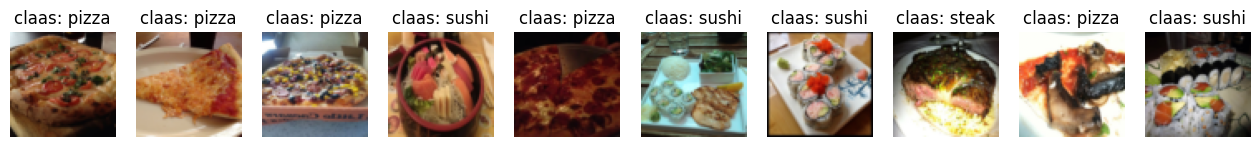

In [ ]:
display_random_images(train_data, classes[0], n=10, display_shape=False)


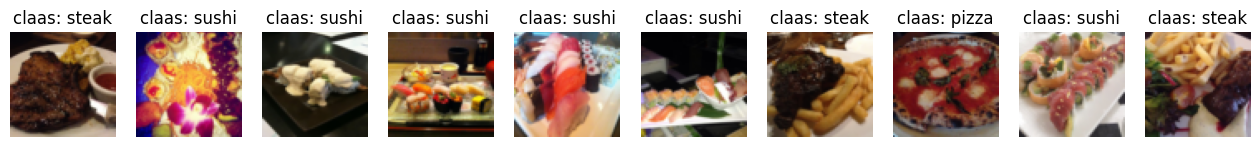

In [ ]:
display_random_images(train_data_custom, classes[0], n=10, display_shape=False)


### Turn Custom loaded Image into DataLoader's


In [ ]:
train_dataloader_custom = DataLoader(
    dataset=train_data_custom, batch_size=1, num_workers=0, shuffle=True
)

train_dataloader_custom


## Data Augumentaion - Other forms of transforms


The Purpose of transform is to alter our image in some way - that may be turning our image into tensor or cropping it
or randomly erasing a portion or randomly rotating them

Doing these kinds of transform is often referred to as data augumentation

Data Augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training data

Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization

`TrivialAugment` : You have a set of transform and you randomly pick a number of them to perform on an image
and at a random magnitude between a given range (higher magnitude means more intense).

`transforms.TrivialAugmentWide()` : parameter to pay attention `num_magnitute_bins=31`

It defines how much of a range an intensity value will be picked to apply a certain transform, 0 being lowest and 31 being higgest


In [ ]:
train_trnasform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor(),
    ]
)


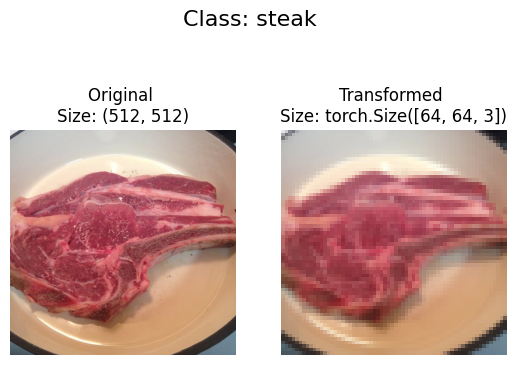

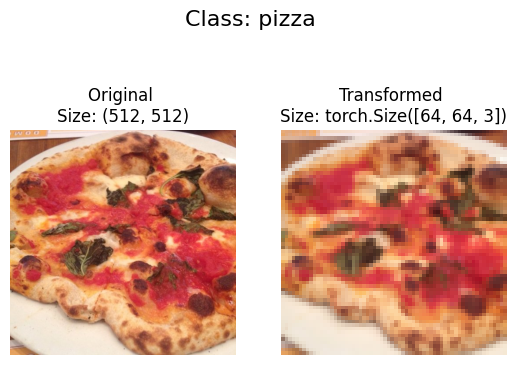

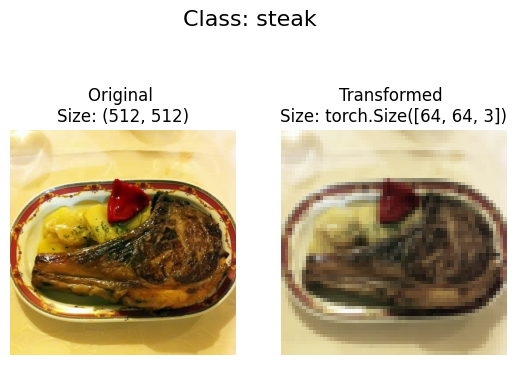

In [ ]:
plot_transformed_images(
    image_path=image_path_list, transforms=train_trnasform, n=3, seed=None
)


The first image is moved to sides , second image is zommed, third one color change can be seen


## Model-0: TinyVGG without Data augmentation


### Creating transforms and loading data for model-0


In [ ]:
simple_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),  # reshape the images
        transforms.ToTensor(),  # convert them into tensors
    ]
)


In [ ]:
# Loading the data into dataset ImageFolder and loading the dataset into DataLoader()

# Dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# DataLoader

BATCH_SIZE = 32
NUM_WORKER = os.cpu_count()


train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKER,
    drop_last=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKER,
    drop_last=True,
)


len(train_dataloader), len(test_dataloader)


(14, 4)

In [ ]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """

    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.conv_2d_batch1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_features,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_2d_batch2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16 * 16, out_features=output_features),
        )

    def forward(self, x):
        # # print(x.shape)
        # x = self.conv_2d_batch1(x)
        # # print(x.shape)
        # x = self.conv_2d_batch2(x)
        # # print(x.shape)
        # x = self.classifier(x)
        # # print(x.shape)
        return self.classifier(
            self.conv_2d_batch2(self.conv_2d_batch1(x))
        )  # operator fusion


In [ ]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

model0 = TinyVGG(input_features=3, output_features=3, hidden_units=10).to(device)
model0


TinyVGG(
  (conv_2d_batch1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2d_batch2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
# doing a forward pass on one image

img_batch, label_batch = next(
    iter(train_dataloader)
)  # this will give us a single batch of image

# getting a single image
img = img_batch[0].unsqueeze(0)
label = label_batch[0]
print(img.shape, label)


with torch.inference_mode():
    logits = model0(img.to(device))

logits.shape

preds = torch.softmax(logits, dim=1)
pred_label = preds.argmax(dim=1)

print(f"Output logits:\n{logits}\n")
print(f"Output prediction probabilities:\n{preds}\n")
print(f"Output prediction label:\n{pred_label.item()}\n")
print(f"Actual label:\n{label}")


torch.Size([1, 3, 64, 64]) tensor(2)
Output logits:
tensor([[0.0649, 0.0630, 0.0391]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3364, 0.3358, 0.3278]], device='cuda:0')

Output prediction label:
0

Actual label:
2


In [41]:
# model0 is our baseline model here as we will not be using any data augmentation with it
try: 
    import torchinfo
except:
    !pip install torchinfo -qq
    import torchinfo

from torchinfo import summary
summary(model0, input_size=[1,3,64,64])
    

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

The output of `torchinfo.summary()` gives us a whole bunch of information about our model

Such as Total params, the total number of parameters in our model, the Estimated Total size (MB) which is the size of our  
Model, the Estimated Total Size (MB) which is the size of our model.


### Creating the Train and test loop function


In [ ]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn: torchmetrics.Accuracy,
    device: torch.device = "cpu",
):
    model.to(device=device)
    model.train()

    accuracy_fn.reset()

    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        logits = model(X)

        loss = loss_fn(logits, y)

        accuracy_fn.update(logits.argmax(dim=1), y)

        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    accuracy = accuracy_fn.compute()
    train_loss = train_loss / len(dataloader)

    return train_loss, accuracy


In [ ]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device,
    accuracy_fn,
):
    # Put model in eval mode
    model.eval()
    model.to(device)
    accuracy_fn.reset()
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)

            accuracy_fn.update(test_pred_logits, y)

            test_loss += loss.item()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = accuracy_fn.compute()
    return test_loss, test_acc


In [ ]:
from tqdm.auto import tqdm

# psudecode
# 1. Take various parameters required for training
# 2. Set the model to correct device and create a dict to store results
# 3. Start the for loop with epochs provide
# 4. call the train_step and test_step
# 5. Print the result
# 6. update the dict


def train(
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn: torchmetrics.Accuracy,
    optimizer_fn: torch.optim.Optimizer,
    test_dataloader: torch.utils.data.DataLoader,
    train_dataloader: torch.utils.data.DataLoader,
    epochs: int = 5,
    device: torch.device = "cpu",
):

    model.to(device)
    result = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer_fn,
            accuracy_fn=accuracy_fn,
            device=device,
        )

        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device,
            accuracy_fn=accuracy_fn,
        )

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        result["train_loss"].append(
            train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss
        )
        result["train_acc"].append(
            train_acc.item() if isinstance(train_acc, torch.Tensor) else train_loss
        )
        result["test_loss"].append(
            test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss
        )
        result["test_acc"].append(
            test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc
        )

    return result


## Train and Evaluate Model 0


In [ ]:
import torchmetrics
from timeit import default_timer as timeit


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_0 = TinyVGG(
    input_features=3, output_features=len(train_data.classes), hidden_units=10
).to(device)


loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = torch.optim.SGD(lr=0.001, params=model_0.parameters())
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=3).to(device)


start_time = timeit()

model_0_result = train(
    model=model_0,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    accuracy_fn=accuracy,
    test_dataloader=test_dataloader,
    train_dataloader=train_dataloader,
    device=device,
    epochs=NUM_EPOCHS,
)

end_time = timeit()

print(f"Total training time: {end_time - start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0990 | train_acc: 0.3326 | test_loss: 1.0957 | test_acc: 0.3516
Epoch: 2 | train_loss: 1.0989 | train_acc: 0.3415 | test_loss: 1.0960 | test_acc: 0.3594
Epoch: 3 | train_loss: 1.0989 | train_acc: 0.3438 | test_loss: 1.0964 | test_acc: 0.3594
Epoch: 4 | train_loss: 1.0987 | train_acc: 0.3438 | test_loss: 1.0967 | test_acc: 0.3594
Epoch: 5 | train_loss: 1.0987 | train_acc: 0.3415 | test_loss: 1.0969 | test_acc: 0.3594
Total training time: 4.005 seconds


It seem like our model performed very poorly


## Plotting loss curve (for train and test data)


In [ ]:
def plot_loss_curve(model_results):
    loss = model_results["train_loss"]
    test_loss = model_results["test_loss"]

    acc = model_results["train_acc"]
    test_acc = model_results["test_acc"]

    plt.figure(figsize=(15, 7))

    epochs = range(len(model_results["train_loss"]))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


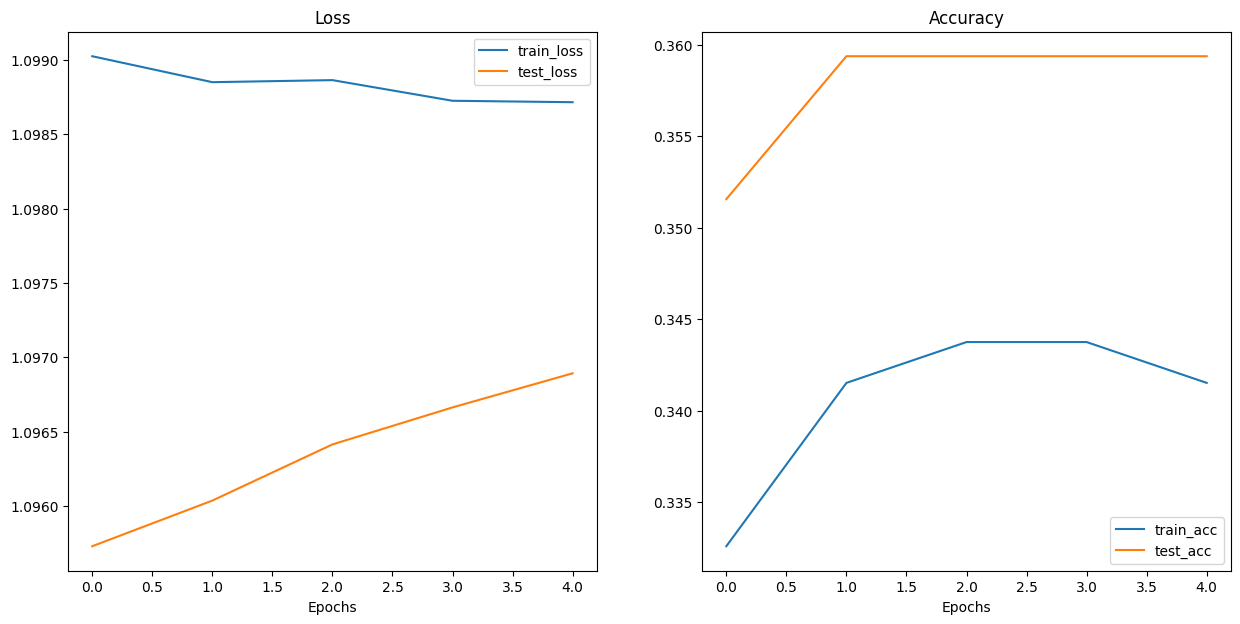

In [ ]:
plot_loss_curve(model_0_result)


through the above plots we can see that theres is a huge difference between the training and testing loss and accuracy


## What should an ideal loss curve look like?


Looking at training and test loss curves is a great way to see if your model is overfitting.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is overfitting.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered underfitting.

The ideal position for a training and test loss curve is for them to line up closely with each other.


[image of overfitting and underfitting]


Left: If your training and test loss curves aren't as low as you'd like, this is considered underfitting. \*Middle: When your test/validation loss is higher than your training loss this is considered overfitting. Right: The ideal scenario is when your training and test loss curves line up over time. This means your model is generalizing well.
